In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

pd.set_option('display.float_format', '{:.3f}'.format)

In [2]:
# load the cleaned data csv
df = pd.read_csv('cleaned_dataset_part1_new.csv')
df['Nurse ID'] = df['Nurse ID'].astype(str)
df

C:\Users\User\AppData\Local\Temp\ipykernel_22296\496466647.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_dataset_part1_new.csv')


,X,Y,Z,Timestamp,Nurse ID,BVP,EDA,HR,TEMP,stress_level,duration_seconds,fraction
0,-24.000,-3.000,57.000,1589036100.000,CE,6.580,0.120,105.680,29.310,2.000,780.000,0.000
1,-17.000,-1.000,54.000,1589036100.250,CE,14.360,0.120,105.760,29.310,2.000,780.000,0.250
2,23.000,-9.000,62.000,1589036100.500,CE,2.550,0.120,105.830,29.310,2.000,780.000,0.500
3,-35.000,12.000,60.000,1589036100.750,CE,36.440,0.110,105.900,29.310,2.000,780.000,0.750
4,-26.000,1.000,57.000,1589036101.000,CE,86.870,0.100,105.980,29.330,2.000,780.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
1313045,-14.000,13.000,57.000,1607827799.000,83,94.070,2.600,87.000,34.790,2.000,1620.000,0.000
1313046,7.000,4.000,73.000,1607827799.250,83,140.050,2.490,87.070,34.790,2.000,1620.000,0.250
1313047,2.000,-9.000,71.000,1607827799.500,83,56.620,2.400,87.140,34.790,2.000,1620.000,0.500
1313048,-23.000,-6.000,60.000,1607827799.750,83,128.870,2.640,87.210,34.790,2.000,1620.000,0.750


In [3]:
# function to create 1-minute windows and aggregate data
def create_minute_windows(df):
    # convert timestamp to datetime
    df['datetime'] = pd.to_datetime(df['Timestamp'], unit='s')
    
    # create minute-level timestamp for grouping
    df['minute_window'] = df['datetime'].dt.floor('1min')
    
    # group by Nurse ID, minute window, and stress level
    grouped = df.groupby(['Nurse ID', 'minute_window', 'stress_level'])
    
    # calculate aggregations for each group
    agg_dict = {
        'X': ['mean', 'std'],
        'Y': ['mean', 'std'],
        'Z': ['mean', 'std'],
        'BVP': ['mean', 'std'],
        'EDA': ['mean', 'std'],
        'HR': ['mean', 'std'],
        'TEMP': ['mean', 'std'],
        'Timestamp': 'count'  # sample count in each window
    }
    
    # aggregating
    windowed_df = grouped.agg(agg_dict)
    
    # flatten column names for easy interpretation
    windowed_df.columns = ['_'.join(col).strip() for col in windowed_df.columns.values]
    
    # reset index to make Nurse ID, minute_window, and stress_level regular columns
    windowed_df = windowed_df.reset_index()
    
    # rename count column to be more descriptive
    windowed_df = windowed_df.rename(columns={'Timestamp_count': 'samples_per_window'})
    
    return windowed_df

# apply the windowing function
windowed_data = create_minute_windows(df)

print("Shape of windowed data:", windowed_data.shape)
windowed_data.head()

Shape of windowed data: (5672, 18)


,Nurse ID,minute_window,stress_level,X_mean,X_std,Y_mean,Y_std,Z_mean,Z_std,BVP_mean,BVP_std,EDA_mean,EDA_std,HR_mean,HR_std,TEMP_mean,TEMP_std,samples_per_window
0,15,2020-07-21 13:23:00,0.000,-35.546,29.967,-3.763,37.450,-4.971,37.818,7.081,207.846,4.891,0.701,95.836,0.979,33.542,0.064,240
1,15,2020-07-21 13:24:00,0.000,-29.204,31.077,-22.704,22.665,-2.654,36.931,1.414,120.570,4.867,0.719,101.032,1.998,33.706,0.172,240
2,15,2020-07-21 13:25:00,0.000,-31.421,37.775,-12.400,25.818,-12.554,32.346,-1.036,99.918,4.025,0.591,98.304,2.346,34.037,0.036,240
3,15,2020-07-21 13:26:00,0.000,-33.612,16.735,1.850,16.769,-25.892,44.181,-1.201,88.186,4.527,0.216,109.153,2.654,34.140,0.038,240
4,15,2020-07-21 13:27:00,0.000,-45.158,21.494,-13.046,30.701,-3.667,30.757,-2.112,103.255,4.359,0.236,99.423,1.224,34.360,0.079,240


In [4]:
windowed_data["samples_per_window"].value_counts()

samples_per_window
240    5466
1       197
232       1
80        1
13        1
168       1
152       1
16        1
132       1
112       1
108       1
Name: count, dtype: int64

In [5]:
# only keep the 240 samples per window records - correspond to having all 250ms(4Hz) entries
windowed_data = windowed_data[windowed_data["samples_per_window"] == 240]

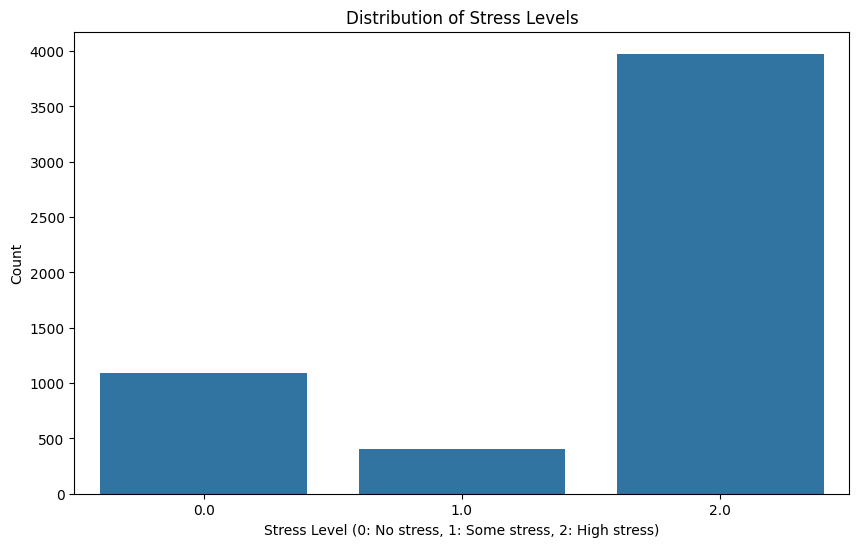

In [6]:
# distribution of overall stress levels
plt.figure(figsize=(10, 6))
sns.countplot(data=windowed_data, x='stress_level')
plt.title('Distribution of Stress Levels')
plt.xlabel('Stress Level (0: No stress, 1: Some stress, 2: High stress)')
plt.ylabel('Count')
plt.show()

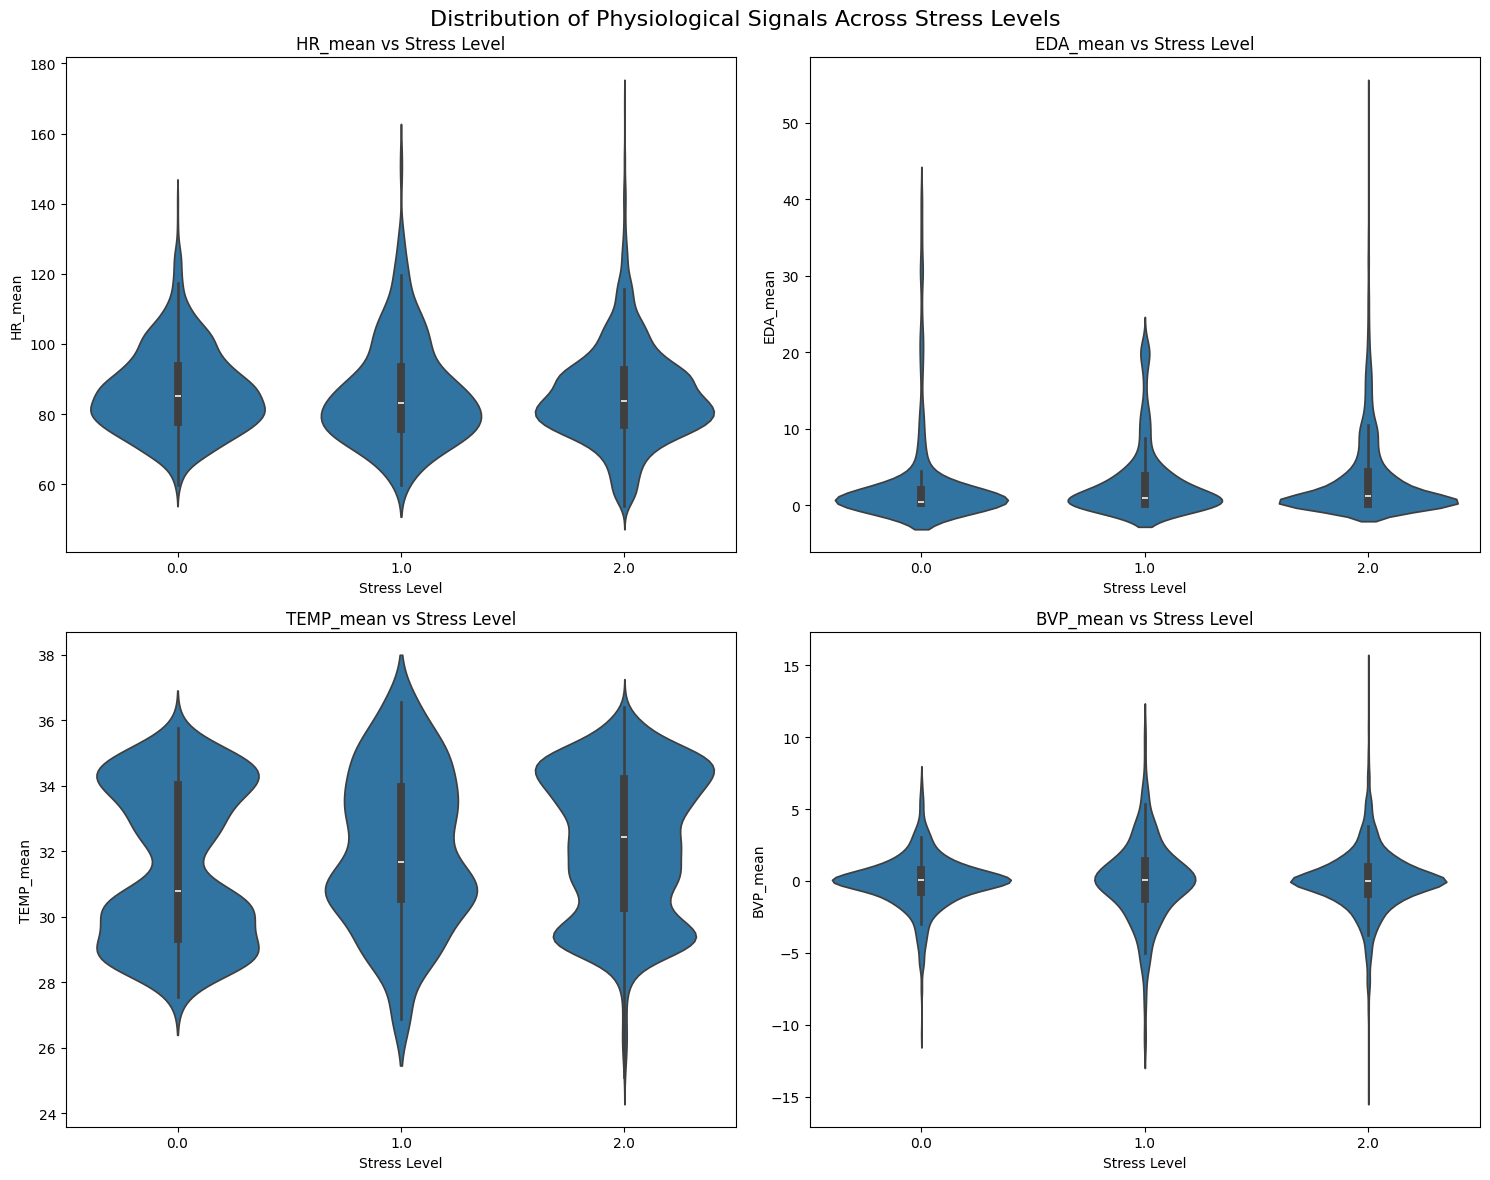

In [7]:
# violin plots for key physiological signals
physiological_vars = ['HR_mean', 'EDA_mean', 'TEMP_mean', 'BVP_mean']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribution of Physiological Signals Across Stress Levels', fontsize=16)

for idx, var in enumerate(physiological_vars):
    row = idx // 2
    col = idx % 2
    sns.violinplot(data=windowed_data, x='stress_level', y=var, ax=axes[row, col])
    axes[row, col].set_title(f'{var} vs Stress Level')
    axes[row, col].set_xlabel('Stress Level')

plt.tight_layout()
plt.show()

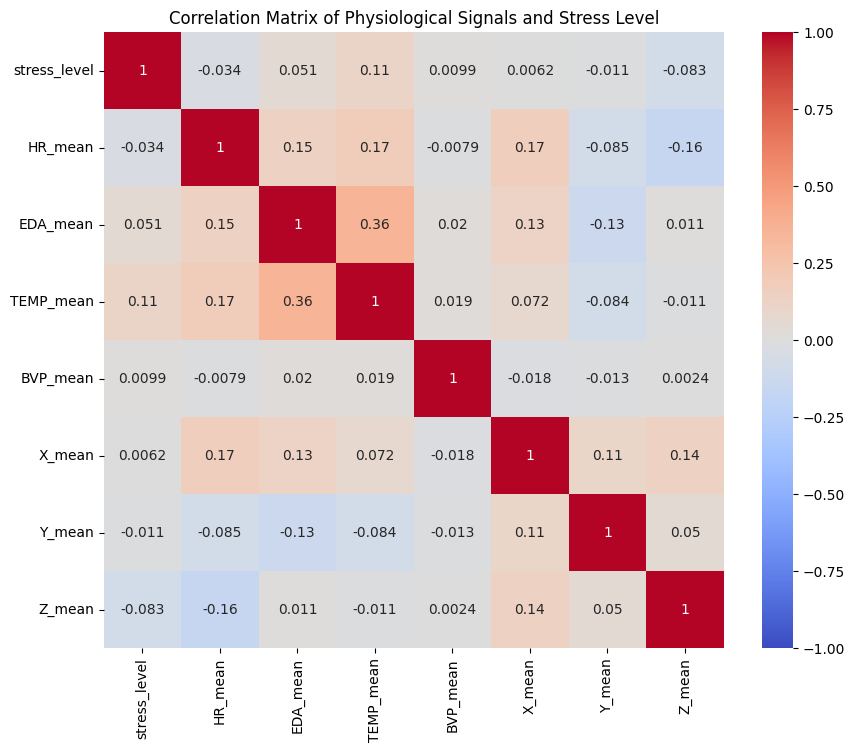

In [8]:
# Overall correlation matrix - Without subject wise evaluation 
correlation_vars = ['stress_level', 'HR_mean', 'EDA_mean', 'TEMP_mean', 'BVP_mean',
                   'X_mean', 'Y_mean', 'Z_mean']

correlation_matrix = windowed_data[correlation_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Physiological Signals and Stress Level')
plt.show()


In [19]:
from scipy.stats import pearsonr
pd.set_option('display.float_format', '{:.10f}'.format)
# Create a DataFrame to store correlations and p-values
correlations = []
p_values = []

for var in correlation_vars:
    # Calculate the Pearson correlation coefficient and p-value
    corr, p = pearsonr(windowed_data["stress_level"], windowed_data[var])
    correlations.append(corr)
    p_values.append(p)

# Create a DataFrame with results
results_df = pd.DataFrame({'Variable': correlation_vars, 'Correlation': correlations, 'P-value': p_values})

print(results_df)

       Variable   Correlation      P-value
0  stress_level  1.0000000000 0.0000000000
1       HR_mean -0.0341819445 0.0114938767
2      EDA_mean  0.0511666156 0.0001540275
3     TEMP_mean  0.1140514059 0.0000000000
4      BVP_mean  0.0098650117 0.4658824242
5        X_mean  0.0062445019 0.6443897584
6        Y_mean -0.0107523033 0.4267387135
7        Z_mean -0.0830233933 0.0000000008


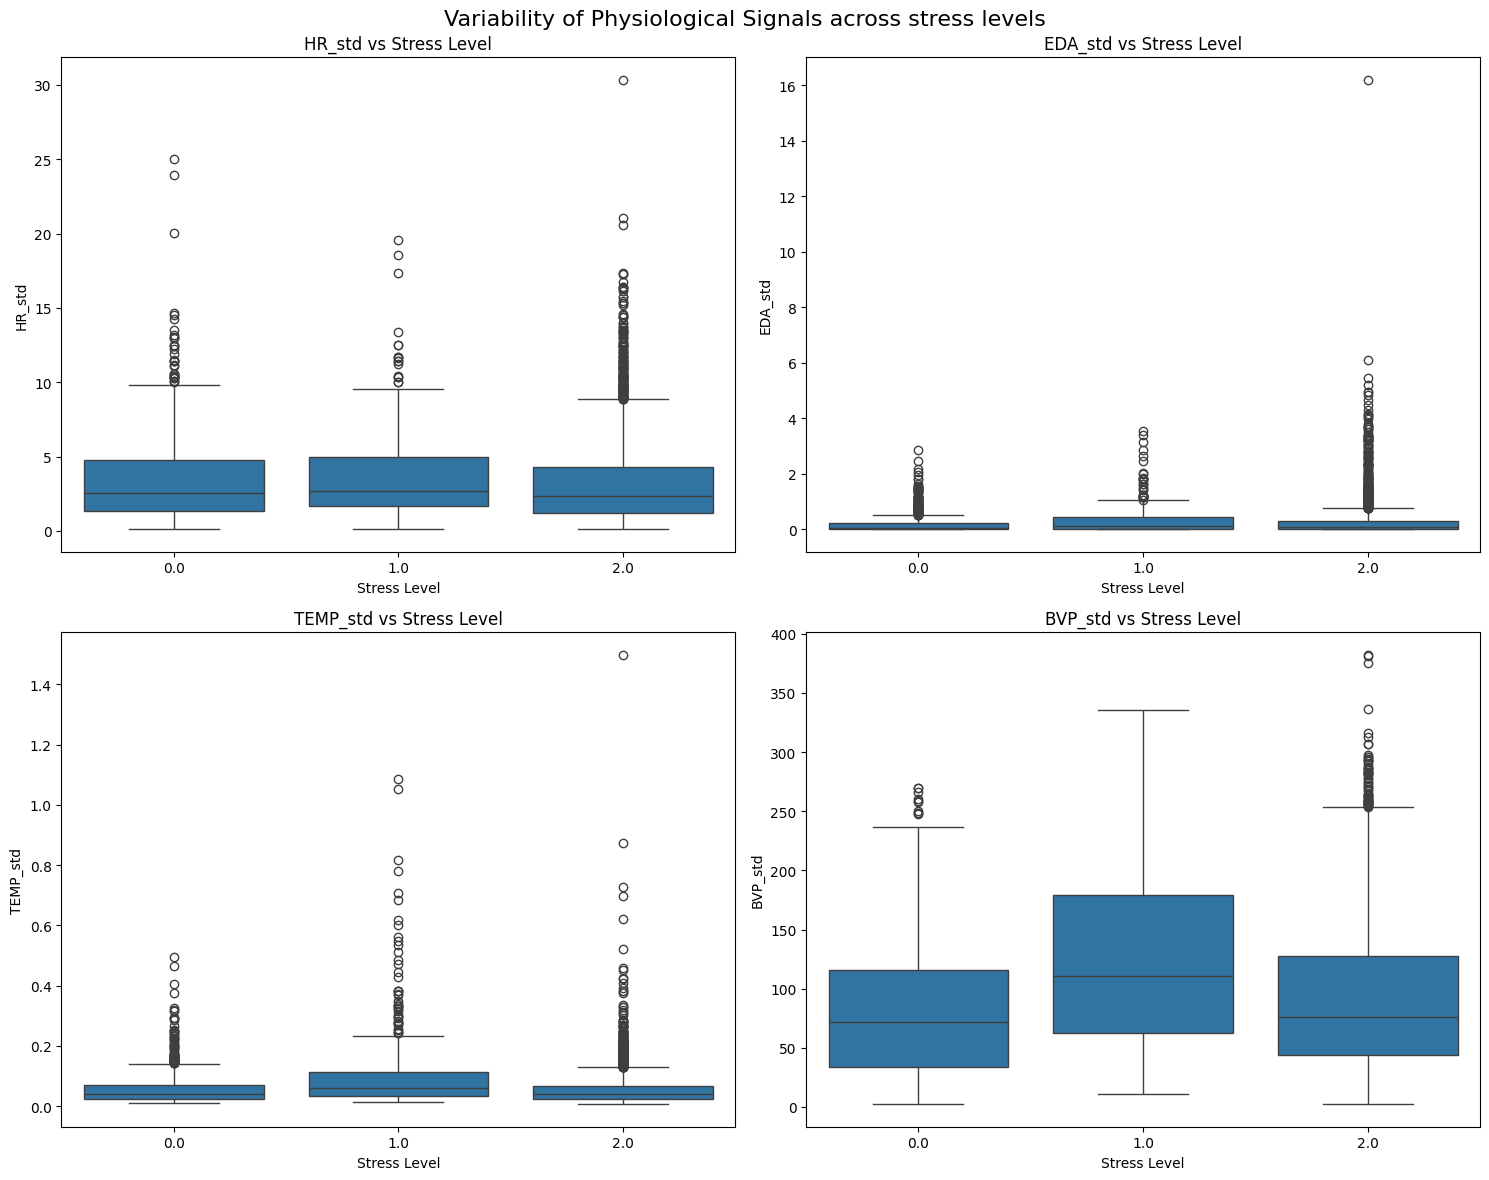

In [9]:
# box plots for signal variability
variability_vars = ['HR_std', 'EDA_std', 'TEMP_std', 'BVP_std']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Variability of Physiological Signals across stress levels', fontsize=16)

for idx, var in enumerate(variability_vars):
    row = idx // 2
    col = idx % 2
    sns.boxplot(data=windowed_data, x='stress_level', y=var, ax=axes[row, col])
    axes[row, col].set_title(f'{var} vs Stress Level')
    axes[row, col].set_xlabel('Stress Level')

plt.tight_layout()
plt.show()

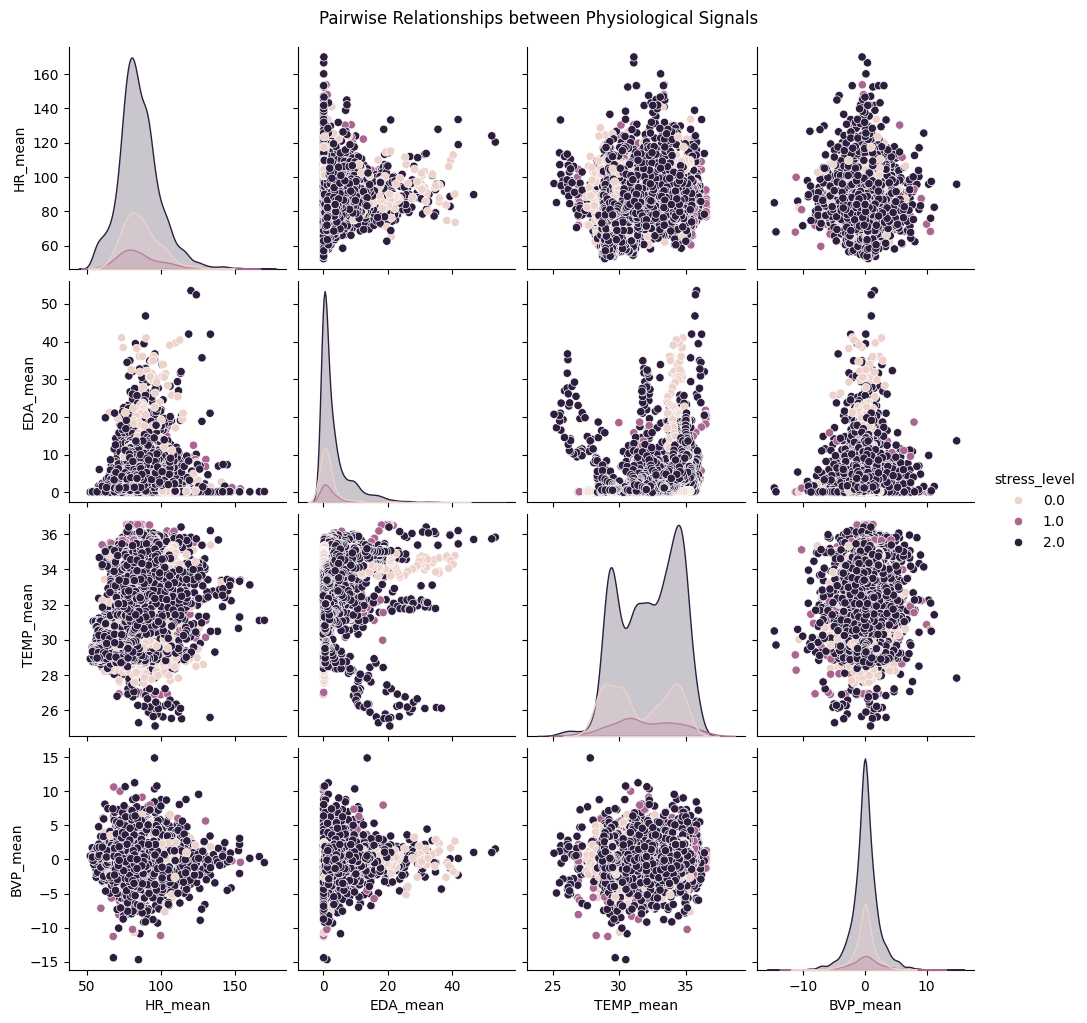

In [10]:
# pairplot of physiological signals
sns.pairplot(windowed_data[['HR_mean', 'EDA_mean', 'TEMP_mean', 'BVP_mean', 'stress_level']],
             hue='stress_level', diag_kind='kde')
plt.suptitle('Pairwise Relationships between Physiological Signals', y=1.02)
plt.show()

In [11]:
# Summary statistics
summary_stats = windowed_data.groupby('stress_level')[['HR_mean', 'EDA_mean', 'TEMP_mean', 'BVP_mean']].describe()
print("\nSummary Statistics by Stress Level:")
display(summary_stats)


Summary Statistics by Stress Level:


HR_mean                                                    \
                count   mean    std    min    25%    50%    75%     max   
stress_level                                                              
0.000        1088.000 86.534 12.150 59.733 77.733 85.136 93.833 140.922   
1.000         402.000 86.077 14.813 59.652 75.601 83.126 93.487 153.806   
2.000        3976.000 85.384 13.975 52.466 76.907 83.794 92.459 170.009   

             EDA_mean        ... TEMP_mean        BVP_mean               \
                count  mean  ...       75%    max    count   mean   std   
stress_level                 ...                                          
0.000        1088.000 2.844  ...    34.022 35.747 1088.000 -0.024 1.809   
1.000         402.000 3.020  ...    33.947 36.560  402.000 -0.015 2.848   
2.000        3976.000 3.553  ...    34.203 36.404 3976.000  0.027 2.189   

                                                
                 min    25%   50%   75%    max  
stress_level                                    
0.000        -10.672 -0.749 0.041 0.772  7.081  
1.000        -11.278 -1.257 0.050 1.405 10.620  
2.000        -14.679 -0.920 0.013 0.982 14.881  

[3 rows x 32 columns]

#### Analysis nurse ID wise since overall comparisons are not accurate and distinct since the signals ranges vary by individual subject

<Figure size 1800x600 with 0 Axes>

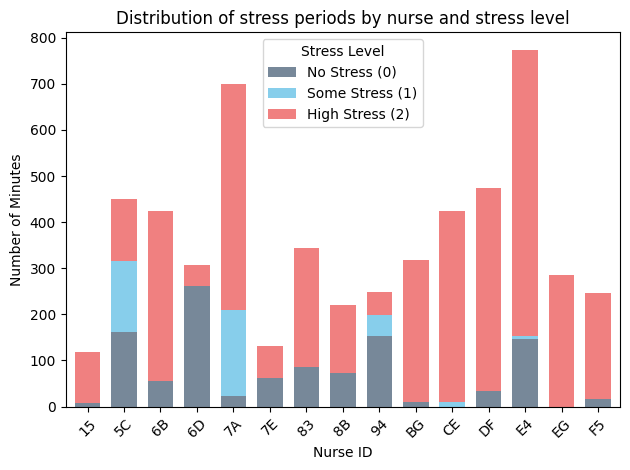

In [12]:
# unique nurse IDs
nurse_ids = windowed_data['Nurse ID'].unique()

plt.figure(figsize=(18, 6))

# a pivot table to count minutes for each nurse and stress level
pivot_data = pd.pivot_table(
    windowed_data,
    values='minute_window',
    index='Nurse ID',
    columns='stress_level',
    aggfunc='count', 
    fill_value=0  # Fill missing combinations with 0
)

# plot stacked bars
pivot_data.plot(
    kind='bar',
    stacked=True,
    width=0.7, 
    color=['lightslategrey','skyblue','lightcoral']
)

plt.title('Distribution of stress periods by nurse and stress level')
plt.xlabel('Nurse ID')
plt.ylabel('Number of Minutes')
plt.xticks(rotation=45)
plt.legend(title='Stress Level', labels=['No Stress (0)', 'Some Stress (1)', 'High Stress (2)'])
plt.tight_layout()
plt.show()

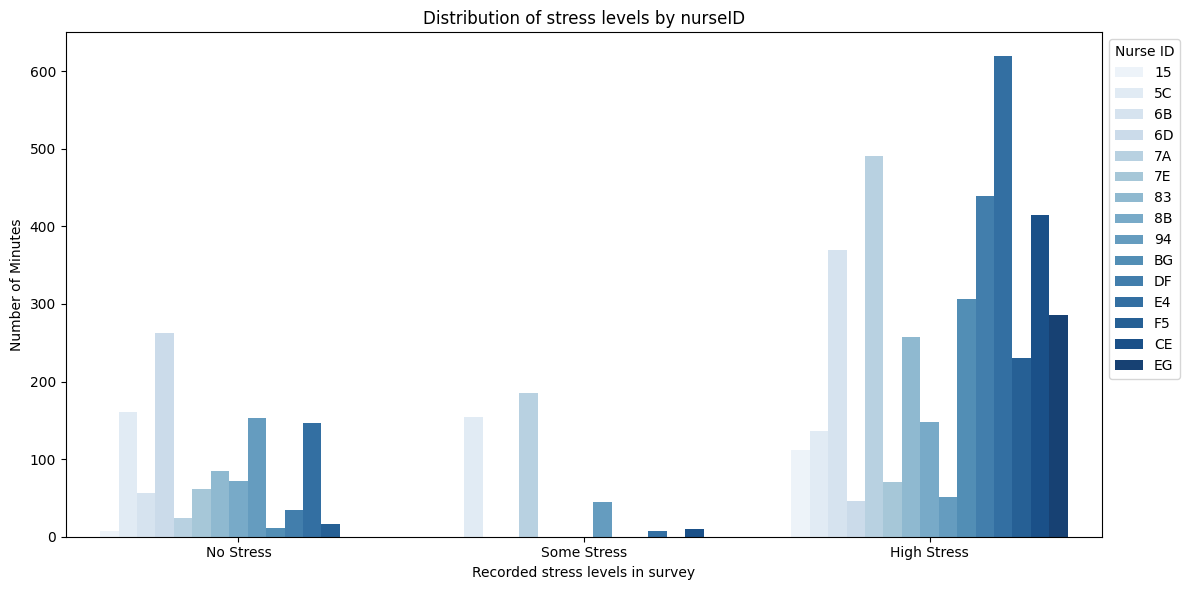

In [13]:
# unique nurse IDs
nurse_ids = windowed_data['Nurse ID'].unique()

# distribution of Stress Levels by Nurse
plt.figure(figsize=(12, 6))
sns.countplot(x='stress_level', hue='Nurse ID', data=windowed_data, palette="Blues")
plt.xticks([0, 1, 2], ['No Stress', 'Some Stress', 'High Stress'])
plt.title('Distribution of stress levels by nurseID')
plt.xlabel('Recorded stress levels in survey')
plt.ylabel('Number of Minutes')
plt.legend(title='Nurse ID', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

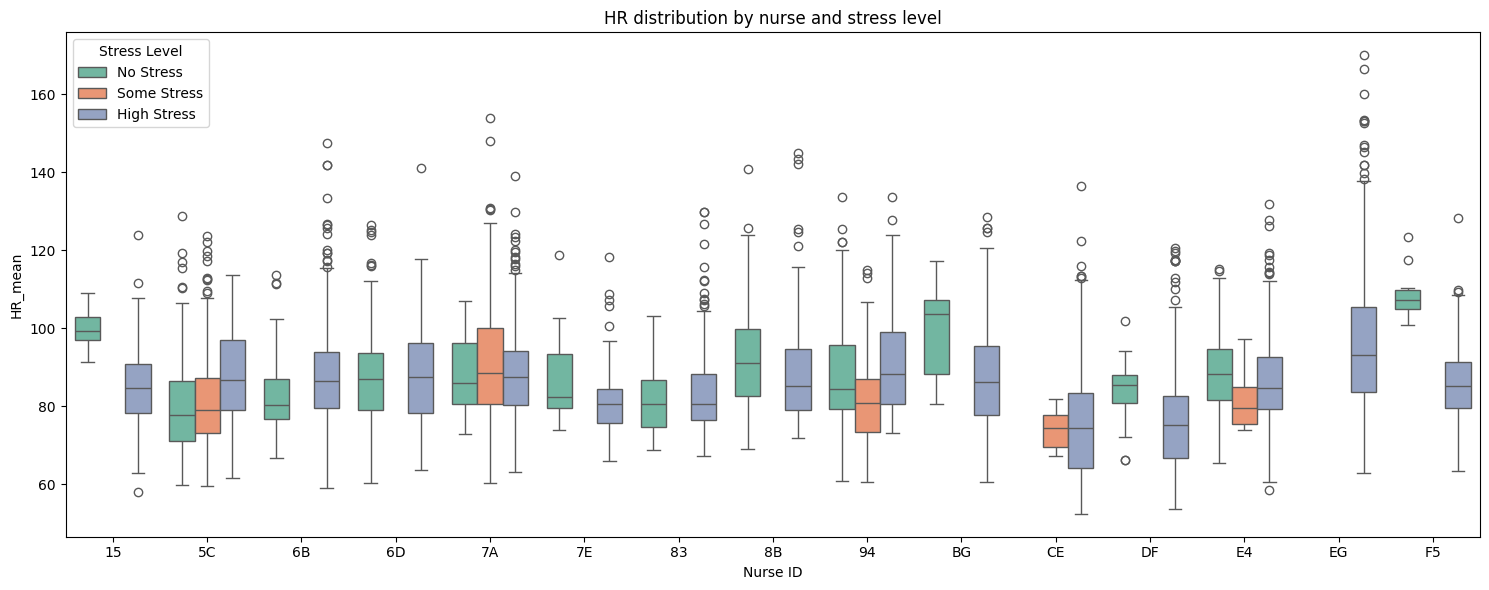

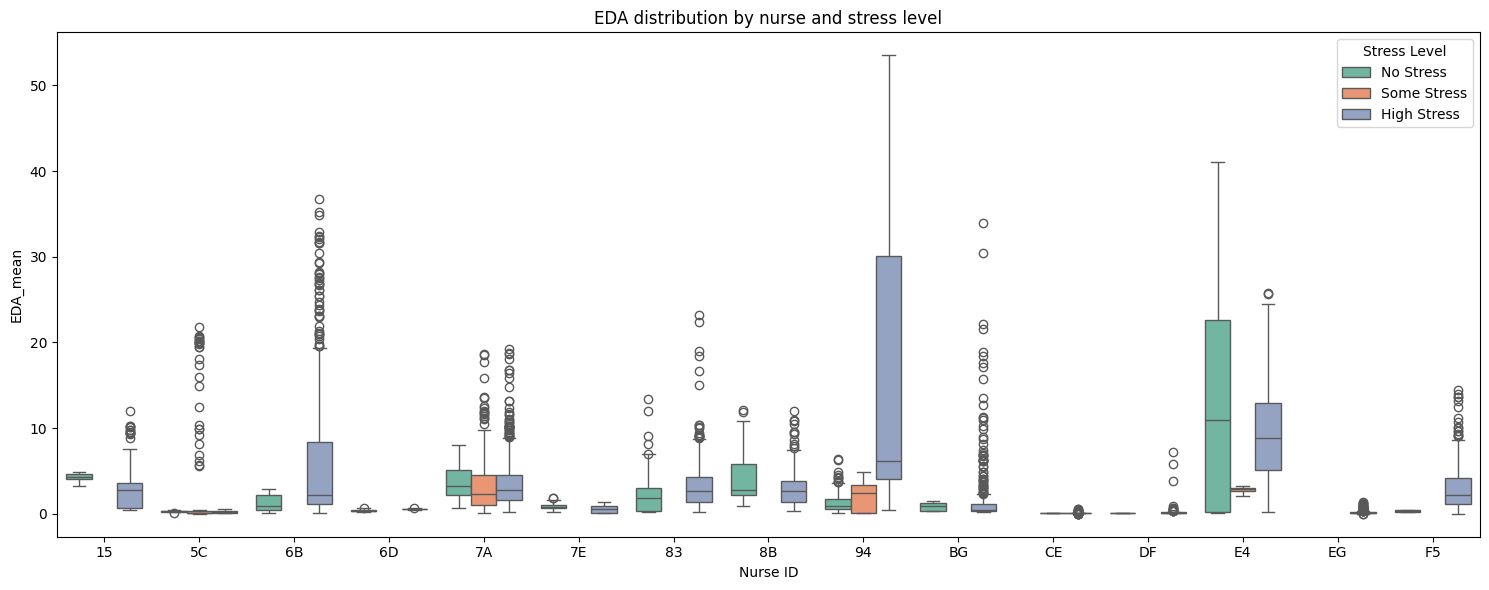

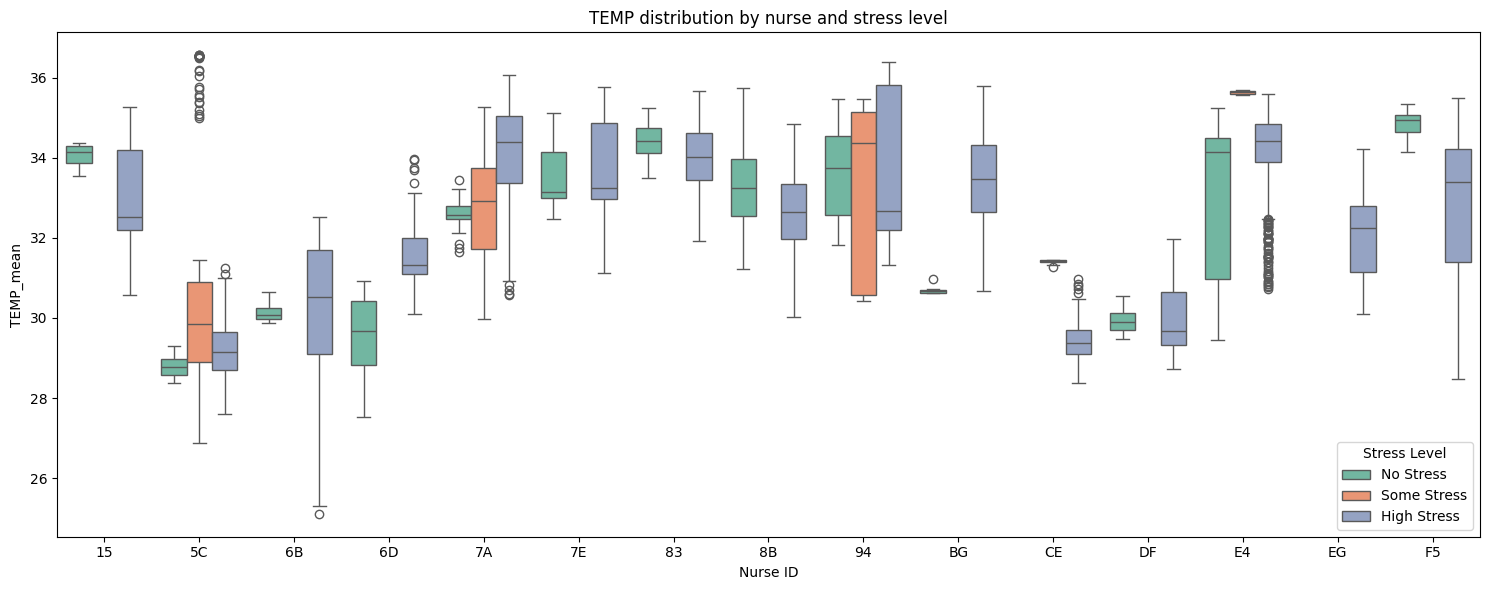

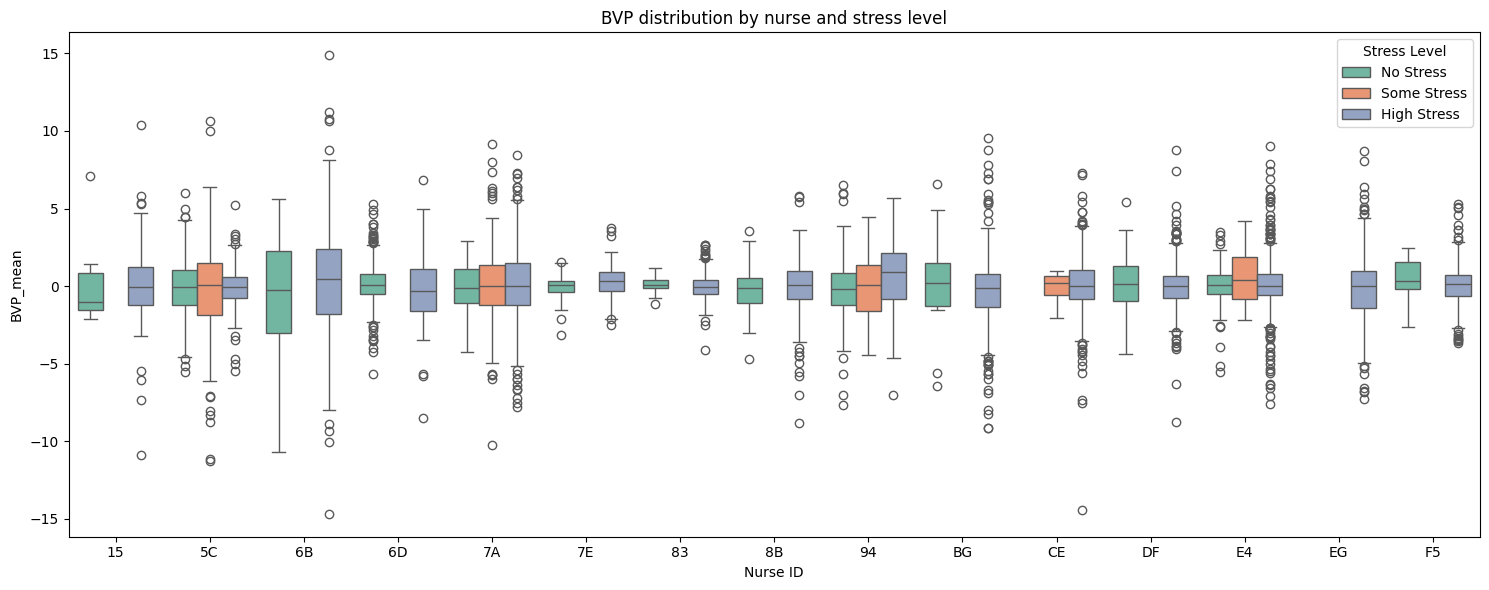

In [14]:
# boxplots for mean values of windowed physiological signals by NurseID
physiological_vars = ['HR_mean', 'EDA_mean', 'TEMP_mean', 'BVP_mean']

for var in physiological_vars:
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=windowed_data, x='Nurse ID', y=var, hue='stress_level', palette="Set2")
    plt.title(f'{var.split("_")[0]} distribution by nurse and stress level')
    handles, _ = plt.gca().get_legend_handles_labels()
    plt.legend(handles, ['No Stress', 'Some Stress', 'High Stress'], title='Stress Level')
    plt.tight_layout()
    plt.show()

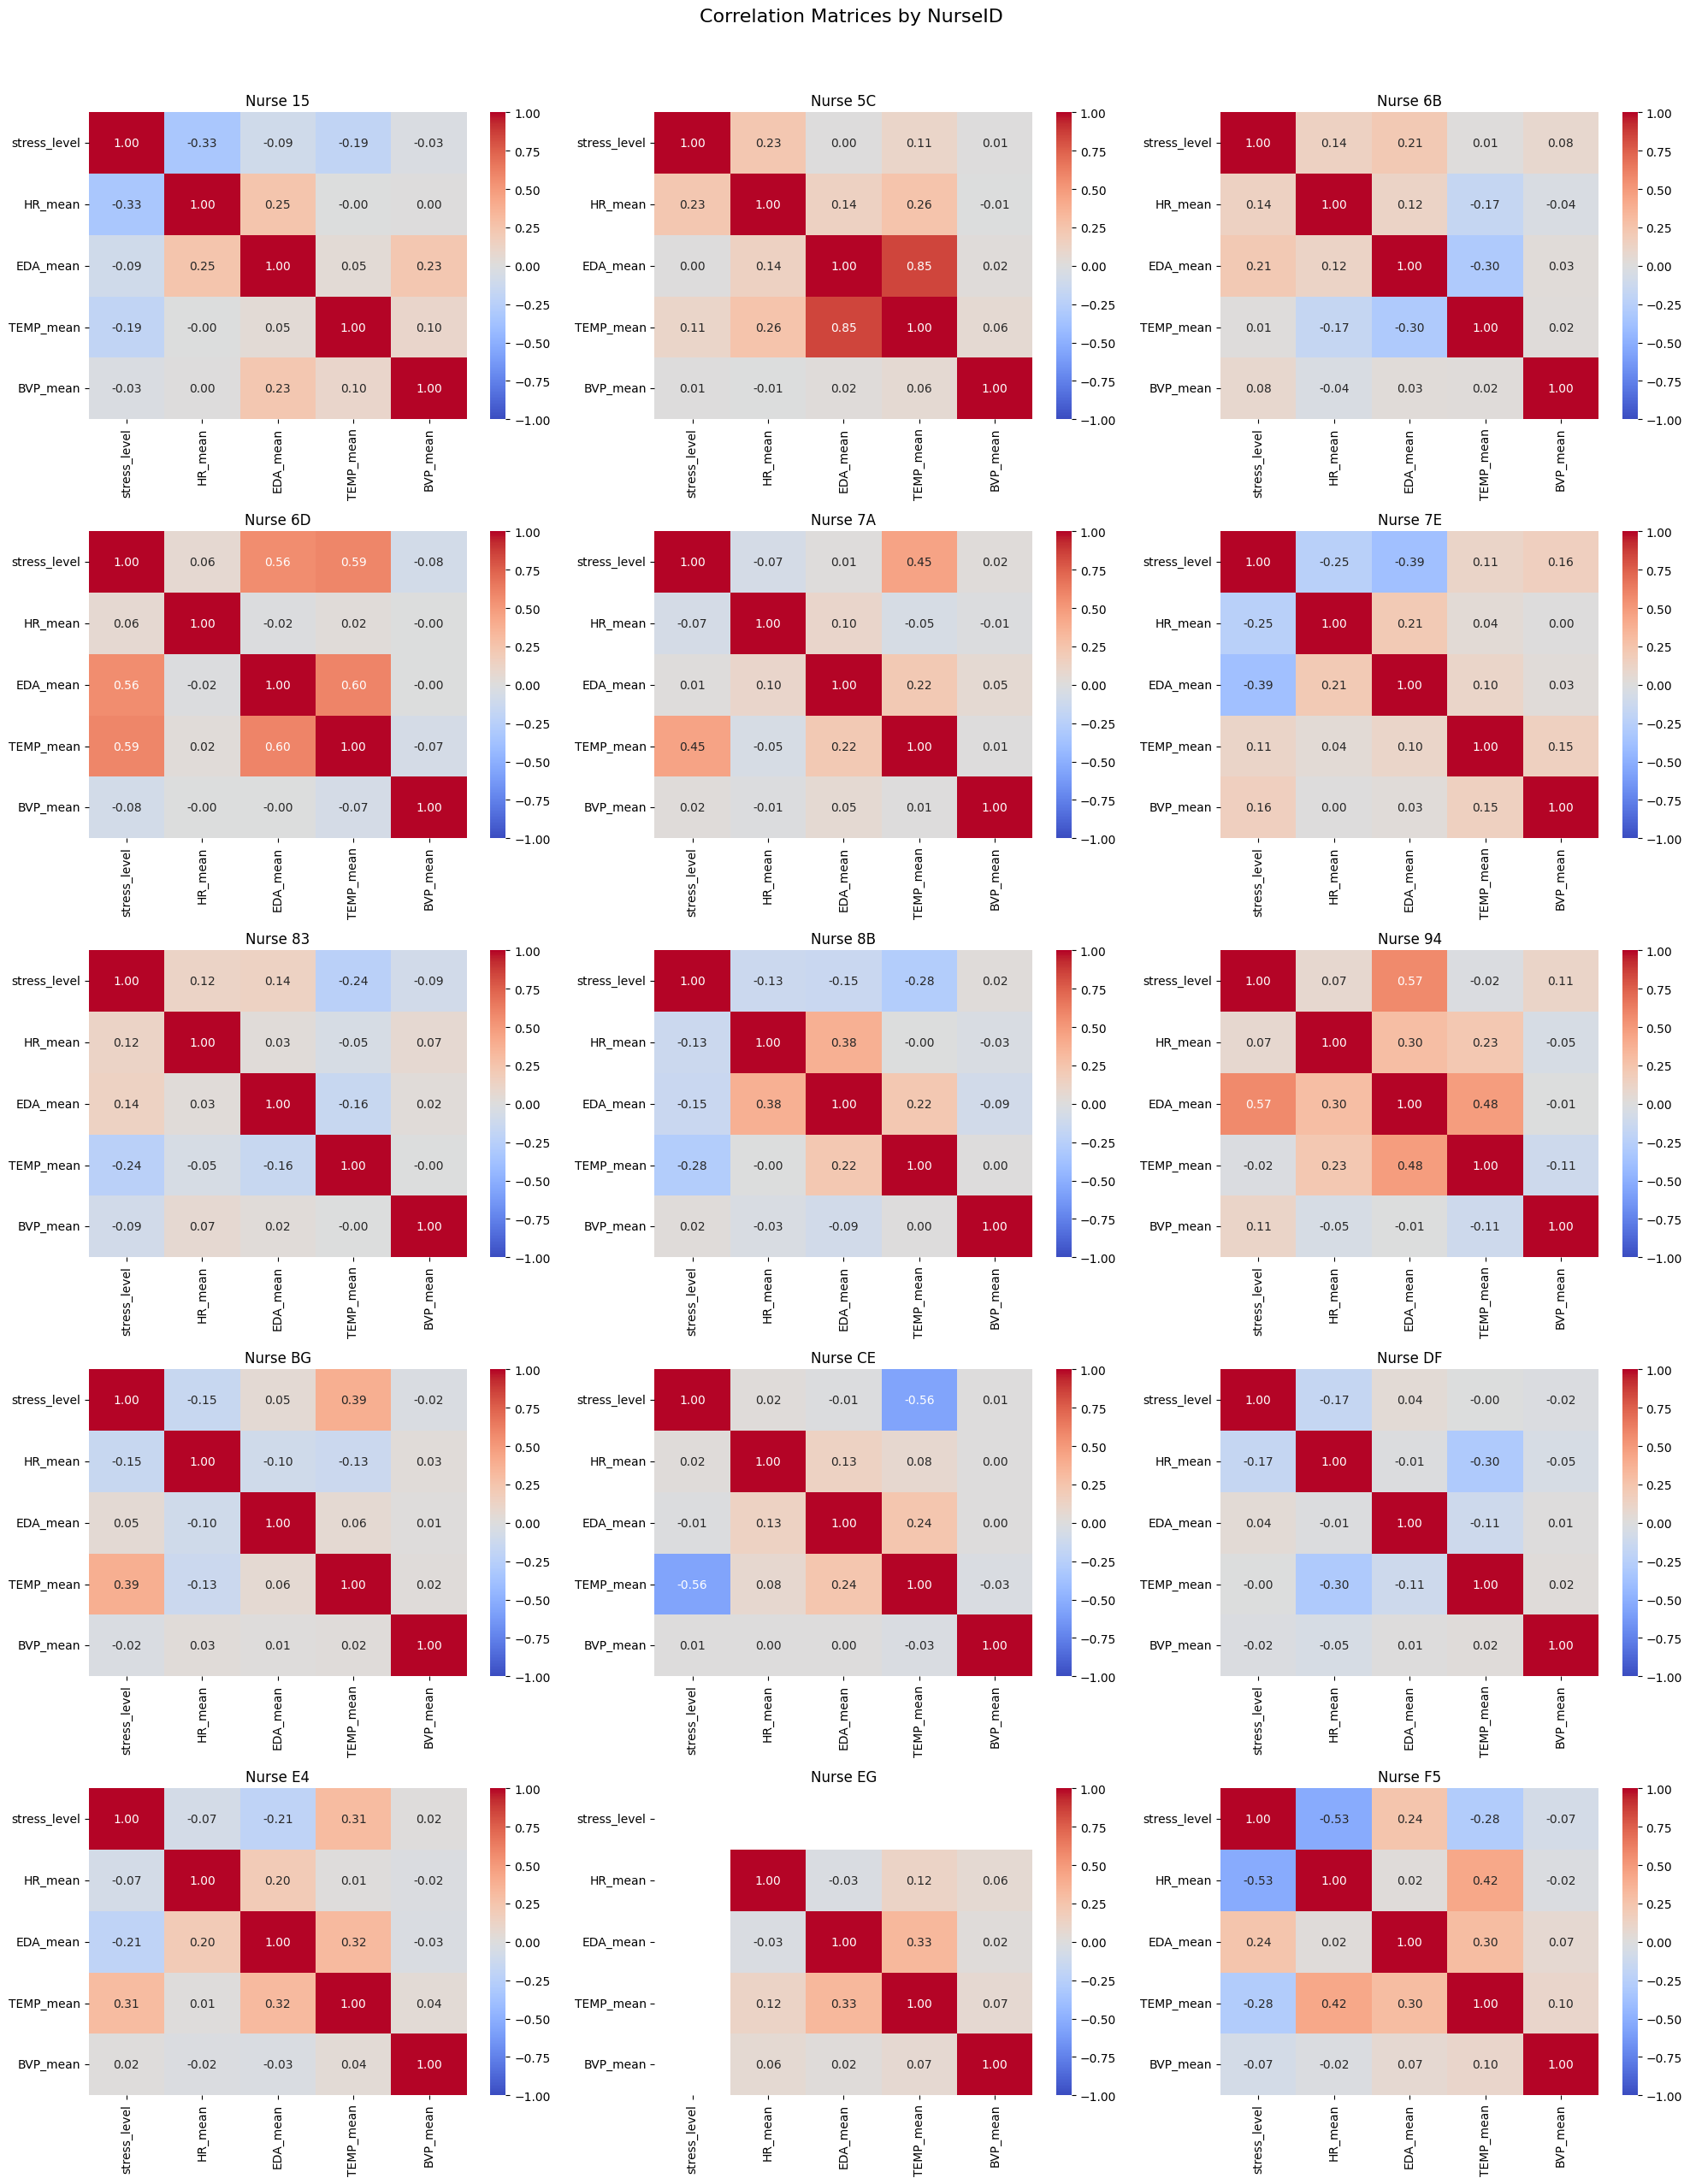

In [15]:
# correlation Analysis for each Nurse
correlation_vars = ['stress_level', 'HR_mean', 'EDA_mean', 'TEMP_mean', 'BVP_mean']
nurse_correlations = {}

# subplots for correlation heatmaps
n_nurses = len(nurse_ids)
n_cols = 3
n_rows = (n_nurses + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.suptitle('Correlation Matrices by NurseID', fontsize=16, y=1.02)

for idx, nurse_id in enumerate(nurse_ids):
    # select a nurse id
    nurse_data = windowed_data[windowed_data['Nurse ID'] == nurse_id]
    
    # calculate correlation matrix
    corr_matrix = nurse_data[correlation_vars].corr()
    nurse_correlations[nurse_id] = corr_matrix
    
    # correlation heatmap dimensions
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                vmin=-1, vmax=1, ax=ax, fmt='.2f')
    ax.set_title(f'Nurse {nurse_id}')

# removing empty subplots if any
if n_nurses < n_rows * n_cols:
    for idx in range(n_nurses, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

plt.tight_layout()
plt.show()

In [16]:
# summary statistics by Nurse
print("\nSummary of correlations with stress level by NurseID:")
summary_correlations = pd.DataFrame({
    nurse_id: nurse_correlations[nurse_id]['stress_level'].drop('stress_level')
    for nurse_id in nurse_ids
}).round(3)
display(summary_correlations)


Summary of correlations with stress level by NurseID:


,15,5C,6B,6D,7A,7E,83,8B,94,BG,CE,DF,E4,EG,F5
HR_mean,-0.329,0.233,0.144,0.064,-0.067,-0.247,0.118,-0.125,0.074,-0.154,0.016,-0.168,-0.072,NaN,-0.525
EDA_mean,-0.095,0.005,0.212,0.558,0.009,-0.386,0.139,-0.148,0.570,0.048,-0.008,0.040,-0.208,NaN,0.244
TEMP_mean,-0.192,0.109,0.014,0.593,0.450,0.112,-0.242,-0.275,-0.020,0.386,-0.563,-0.004,0.310,NaN,-0.285
BVP_mean,-0.029,0.008,0.081,-0.080,0.019,0.159,-0.087,0.016,0.115,-0.024,0.006,-0.023,0.016,NaN,-0.071


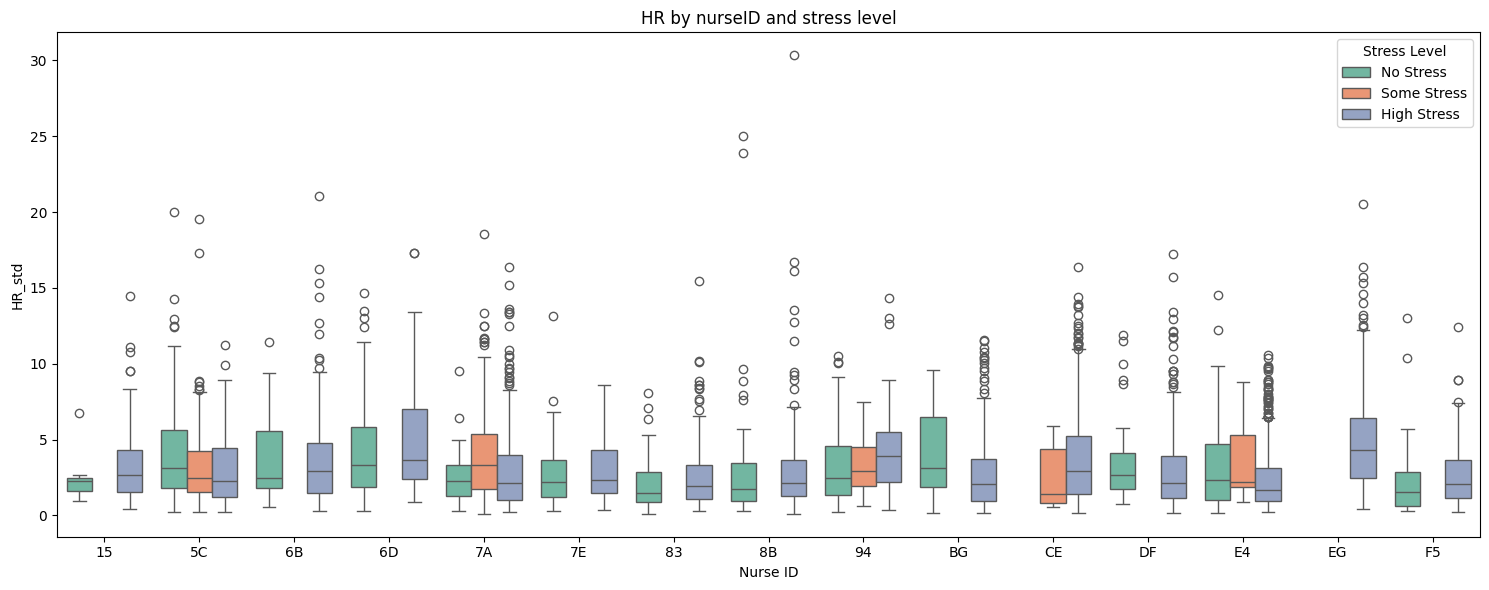

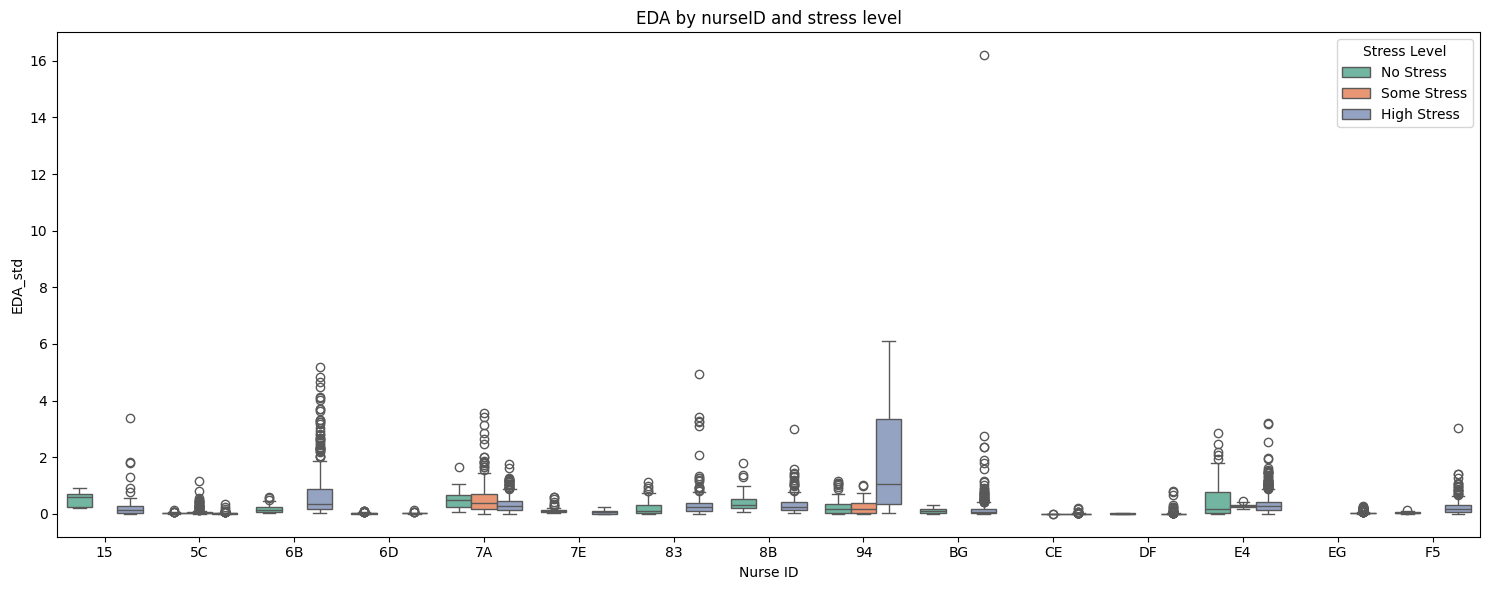

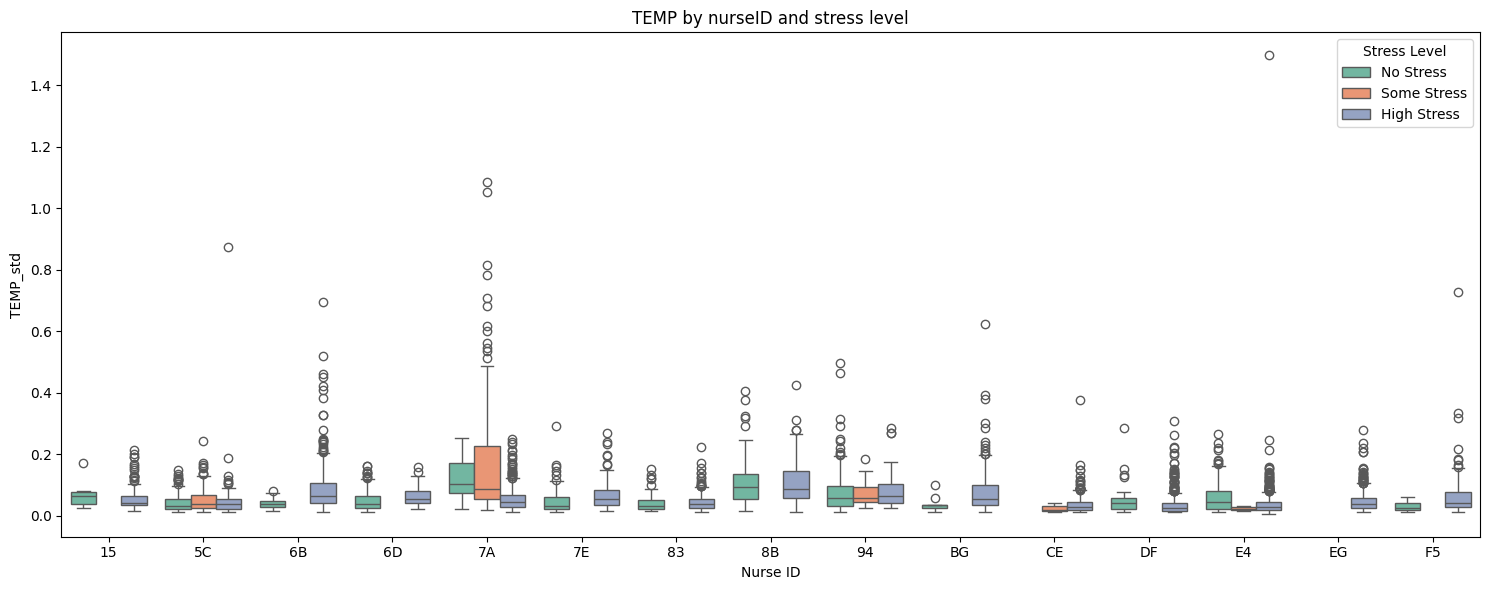

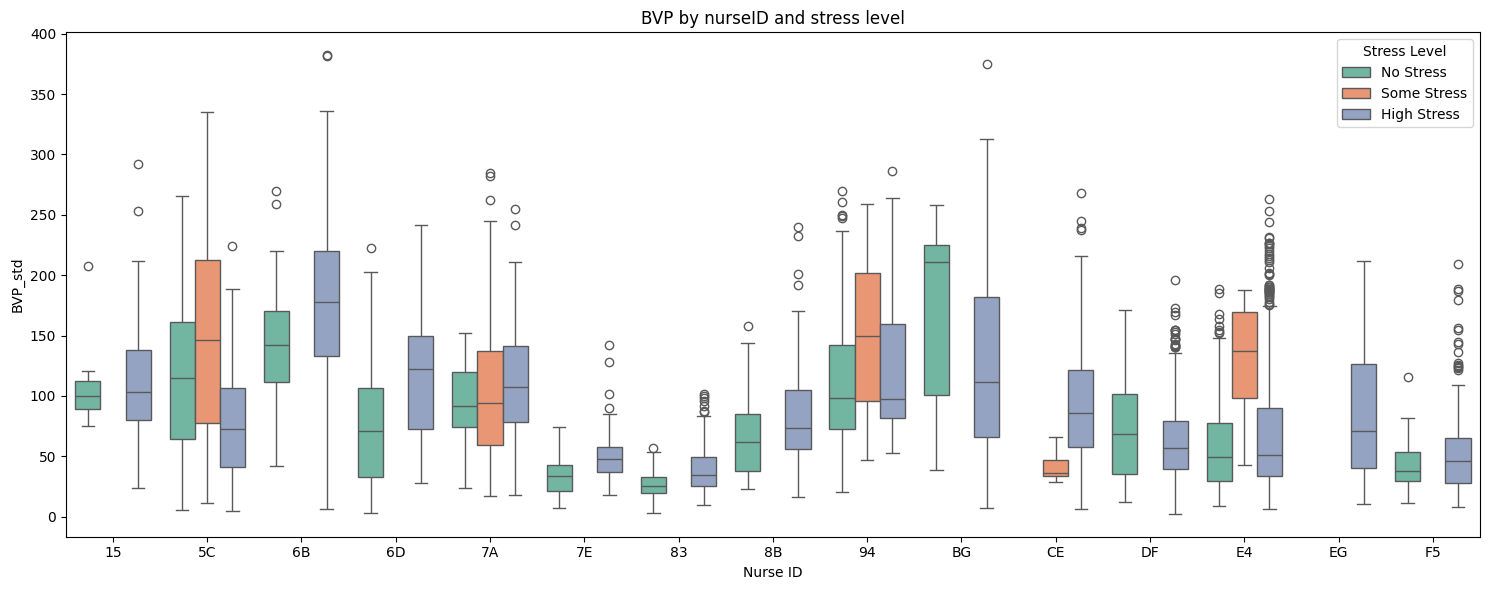

In [17]:
# signal variability analysis by NurseID with std aggregated window values
variability_vars = ['HR_std', 'EDA_std', 'TEMP_std', 'BVP_std']

for var in variability_vars:
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=windowed_data, x='Nurse ID', y=var, hue='stress_level', palette="Set2")
    plt.title(f'{var.split("_")[0]} by nurseID and stress level')
    plt.legend(handles, ['No Stress', 'Some Stress', 'High Stress'], title='Stress Level')
    plt.tight_layout()
    plt.show()

<Figure size 400x400 with 0 Axes>

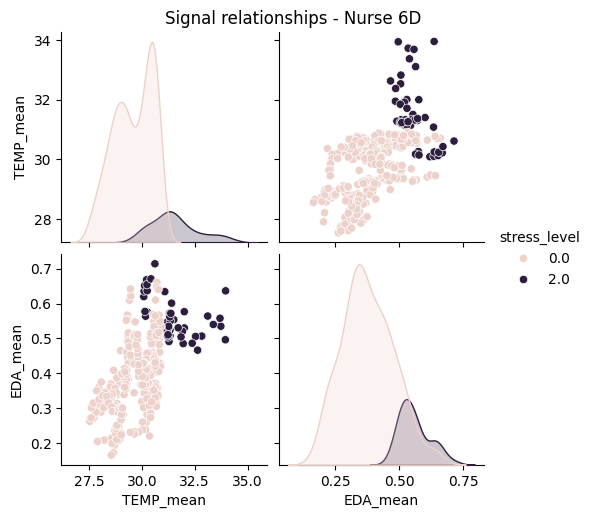

<Figure size 400x400 with 0 Axes>

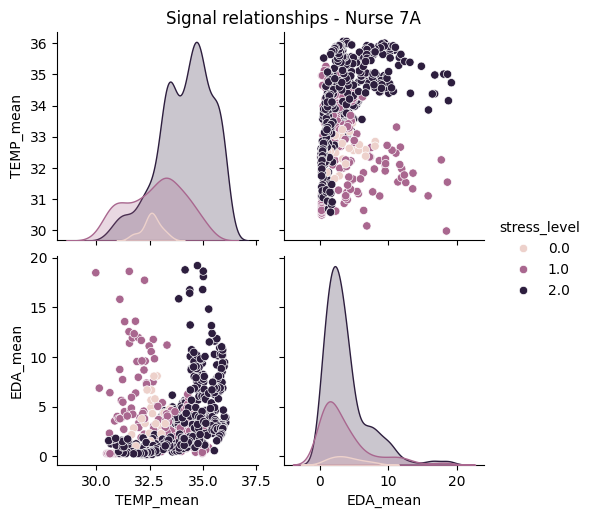

<Figure size 400x400 with 0 Axes>

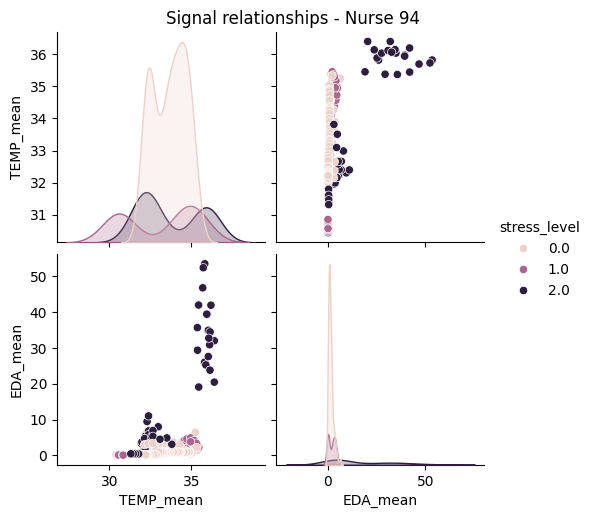

<Figure size 400x400 with 0 Axes>

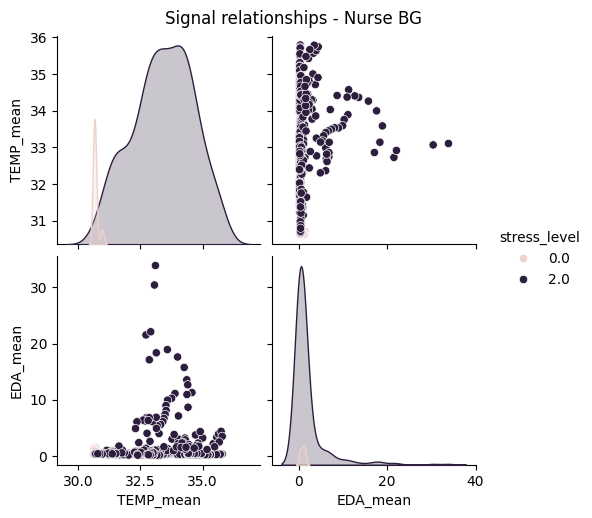

In [18]:
# individual nurse pairplots (for a few key nurseIDs)["5C", "7A", "94", "E4"]
for nurse_id in ["6D", "7A", "94", "BG"]:
    nurse_data = windowed_data[windowed_data['Nurse ID'] == nurse_id]
    plt.figure(figsize=(4, 4))
    
    # pairplot for each nurse
    sns.pairplot(nurse_data[['TEMP_mean', 'EDA_mean', 'stress_level']], 
                hue='stress_level', diag_kind='kde')
    plt.suptitle(f'Signal relationships - Nurse {nurse_id}', y=1.02)
    plt.show()

#### Correlations

In [ ]:
# filter data for specific nurse IDs
#selected_nurses = ["5C", "7A", "94", "E4"]
selected_nurses = ["6D", "7A", "94", "BG"]
selected_data = windowed_data[windowed_data['Nurse ID'].isin(selected_nurses)]

# define signals to analyze
signals = ['HR_mean', 'EDA_mean', 'TEMP_mean', 'BVP_mean'] 
          #'HR_std', 'EDA_std', 'TEMP_std', 'BVP_std']

# empty DataFrames to store correlations
pearson_correlations = pd.DataFrame(index=signals, columns=selected_nurses)
spearman_correlations = pd.DataFrame(index=signals, columns=selected_nurses)

# calculate correlations for each nurse
for nurse in selected_nurses:
    nurse_data = selected_data[selected_data['Nurse ID'] == nurse]
    
    # Pearson correlations
    pearson_corr = nurse_data[signals].corrwith(nurse_data['stress_level'], method='pearson')
    pearson_correlations[nurse] = pearson_corr
    
    # Spearman correlations
    spearman_corr = nurse_data[signals].corrwith(nurse_data['stress_level'], method='spearman')
    spearman_correlations[nurse] = spearman_corr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# heatmap for Pearson correlations
sns.heatmap(pearson_correlations, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, ax=ax1, fmt='.3f')
ax1.set_title('Pearson correlations with stress level by NurseID')

# heatmap for Spearman correlations
sns.heatmap(spearman_correlations, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, ax=ax2, fmt='.3f')
ax2.set_title('Spearman correlations with stress level by NurseID')

plt.tight_layout()
plt.show()

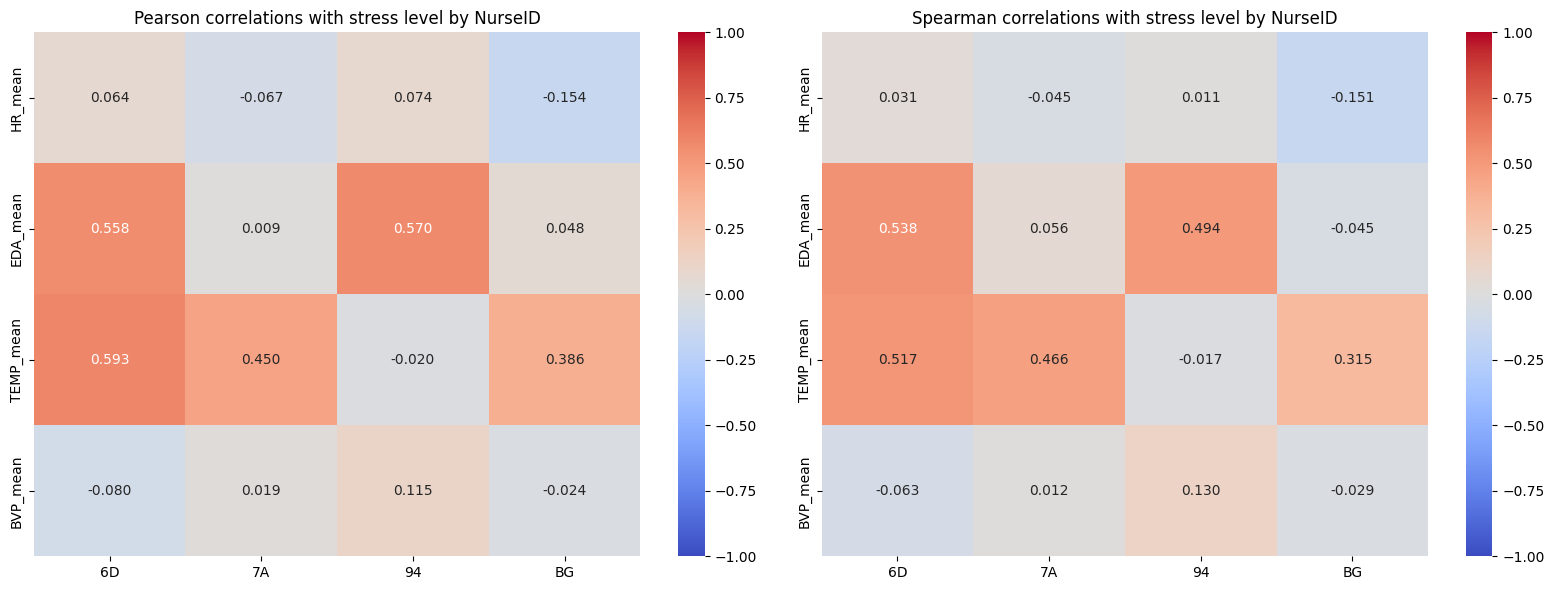

Pearson Correlation P-Values:
                     6D           7A           94           BG
HR_mean   0.2664137068 0.0784311527 0.2442524341 0.0058606782
EDA_mean  0.0000000000 0.8209544365 0.0000000000 0.3899706516
TEMP_mean 0.0000000000 0.0000000000 0.7545586160 0.0000000000
BVP_mean  0.1606684511 0.6222456485 0.0710523405 0.6695527977
Spearman Correlation P-Values:
                     6D           7A           94           BG
HR_mean   0.5824047549 0.2346371189 0.8586305579 0.0069088346
EDA_mean  0.0000000000 0.1372057593 0.0000000000 0.4244411368
TEMP_mean 0.0000000000 0.0000000000 0.7887241352 0.0000000097
BVP_mean  0.2718670106 0.7574426800 0.0408909315 0.6022265719


In [18]:
from scipy.stats import pearsonr, spearmanr
pd.set_option('display.float_format', lambda x: f'{x:.10f}')  # Set decimal places for better display

# Initialize DataFrames for p-values
pearson_p_values = pd.DataFrame(index=signals, columns=selected_nurses)
spearman_p_values = pd.DataFrame(index=signals, columns=selected_nurses)

# Calculate correlations and p-values for each nurse
for nurse in selected_nurses:
    nurse_data = selected_data[selected_data["Nurse ID"] == nurse]
    
    for signal in signals:
        # Pearson correlation and p-value
        pearson_corr, pearson_p = pearsonr(nurse_data[signal], nurse_data["stress_level"])
        pearson_correlations.loc[signal, nurse] = pearson_corr
        pearson_p_values.loc[signal, nurse] = pearson_p
        
        # Spearman correlation and p-value
        spearman_corr, spearman_p = spearmanr(nurse_data[signal], nurse_data["stress_level"])
        spearman_correlations.loc[signal, nurse] = spearman_corr
        spearman_p_values.loc[signal, nurse] = spearman_p

# heatmap for Pearson correlations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(pearson_correlations, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, ax=ax1, fmt='.3f')
ax1.set_title('Pearson correlations with stress level by NurseID')

# heatmap for Spearman correlations
sns.heatmap(spearman_correlations, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, ax=ax2, fmt='.3f')
ax2.set_title('Spearman correlations with stress level by NurseID')

plt.tight_layout()
plt.show()

# Display p-values as separate tables
print("Pearson Correlation P-Values:\n", pearson_p_values)
print("Spearman Correlation P-Values:\n", spearman_p_values)

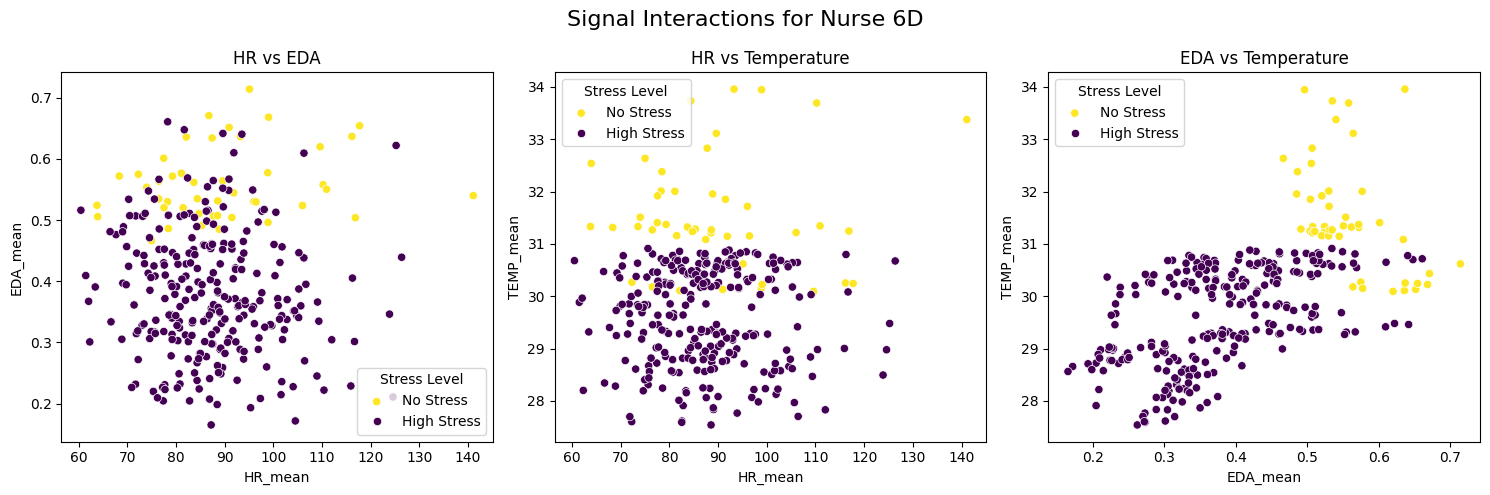

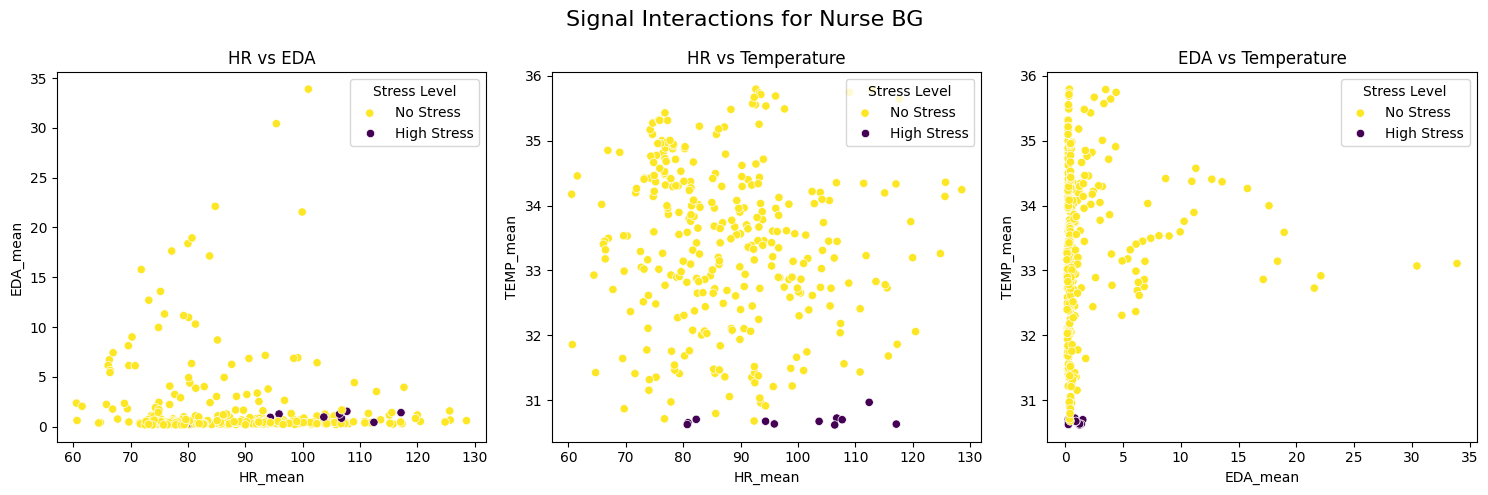

In [20]:
# joint plots for signal interactions
for nurse_id in ["6D","BG"]:
    nurse_data = windowed_data[windowed_data['Nurse ID'] == nurse_id]
    
    plt.figure(figsize=(15, 5))
    plt.suptitle(f'Signal Interactions for Nurse {nurse_id}', fontsize=16)
    
    # HR vs EDA
    plt.subplot(131)
    sns.scatterplot(data=nurse_data, x='HR_mean', y='EDA_mean', hue='stress_level', 
                   palette='viridis')
    plt.legend(title='Stress Level', labels=['No Stress','High Stress'])
    plt.title('HR vs EDA')
    
    # HR vs TEMP
    plt.subplot(132)
    sns.scatterplot(data=nurse_data, x='HR_mean', y='TEMP_mean', hue='stress_level', 
                   palette='viridis')
    plt.legend(title='Stress Level', labels=['No Stress','High Stress'])

    plt.title('HR vs Temperature')
    
    # EDA vs TEMP
    plt.subplot(133)
    sns.scatterplot(data=nurse_data, x='EDA_mean', y='TEMP_mean', hue='stress_level', 
                   palette='viridis')
    plt.legend(title='Stress Level', labels=['No Stress','High Stress'])

    plt.title('EDA vs Temperature')
    
    plt.tight_layout()
    plt.show()